<h2>Importing Libraries</h2>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('ML AssignmentDataset.csv', sep =";")

<h2>Preprocessing the Data</h2>

In [ ]:
# Display first 5 rows
df.head()

Longitude  Latitude
0  36.861544 -5.177747
1  51.463766  5.392935
2  51.190492  4.453765
3  51.326247  6.085953
4  51.463766  5.392935

In [ ]:
# Display last 5 rows
df.tail()

Longitude   Latitude
9890  54.259133  -2.832702
9891  47.771913   1.642025
9892  51.973487   4.133423
9893  50.207400   7.336791
9894  37.290131  13.586804

In [ ]:
df.info

<bound method DataFrame.info of       Longitude   Latitude
0     36.861544  -5.177747
1     51.463766   5.392935
2     51.190492   4.453765
3     51.326247   6.085953
4     51.463766   5.392935
...         ...        ...
9890  54.259133  -2.832702
9891  47.771913   1.642025
9892  51.973487   4.133423
9893  50.207400   7.336791
9894  37.290131  13.586804

[9895 rows x 2 columns]>

In [ ]:
df.describe()

Longitude     Latitude
count  9895.000000  9895.000000
mean     47.798423     4.763722
std       5.779548     8.706026
min      34.910655   -10.466312
25%      41.322100    -1.787456
50%      49.654149     0.742880
75%      52.661300    11.692222
max      59.450561    45.307594

In [ ]:
# Check for missing values
print(df.isnull().sum())

Longitude    0
Latitude     0
dtype: int64


<h2>Visualizing the Data</h2>

In [ ]:
import matplotlib.pyplot as plt

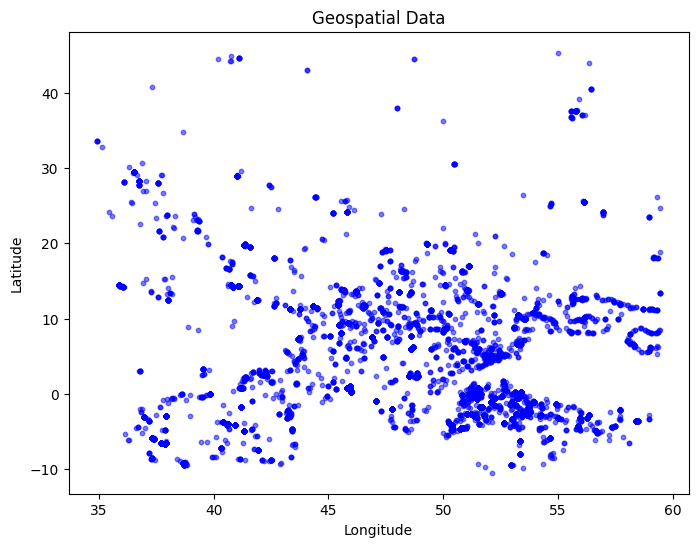

In [ ]:
# Plot the raw locations
plt.figure(figsize=(8, 6))
plt.scatter(df['Longitude'], df['Latitude'], alpha=0.5, s=10, color='blue')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geospatial Data")
plt.show()

<h2>Applying Standardization</h2>

In [ ]:
from sklearn.preprocessing import StandardScaler
# Extract features (Latitude and Longitude)
X = df[['Latitude', 'Longitude']].values

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

<h2>Selecting Clustering Models</h2>

<h3>1) K-Means Clustering</h3>

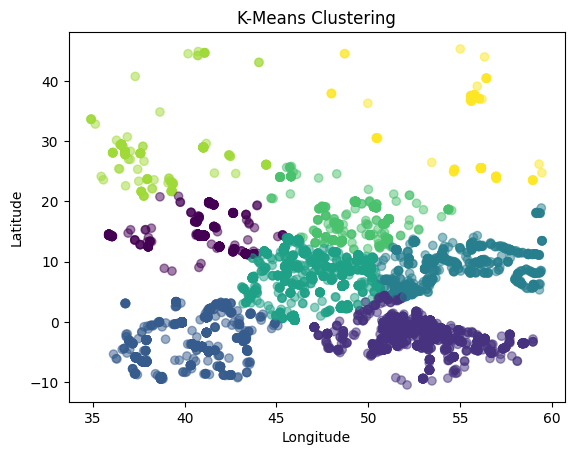

In [ ]:
from sklearn.cluster import KMeans

# Fit K-Means with an arbitrary number of clusters (let's start with 4)
kmeans = KMeans(n_clusters=8, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

# Visualize results
plt.scatter(df['Longitude'], df['Latitude'], c=df['kmeans_cluster'], cmap='viridis', alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("K-Means Clustering")
plt.show()

Execution time: 51.60 seconds


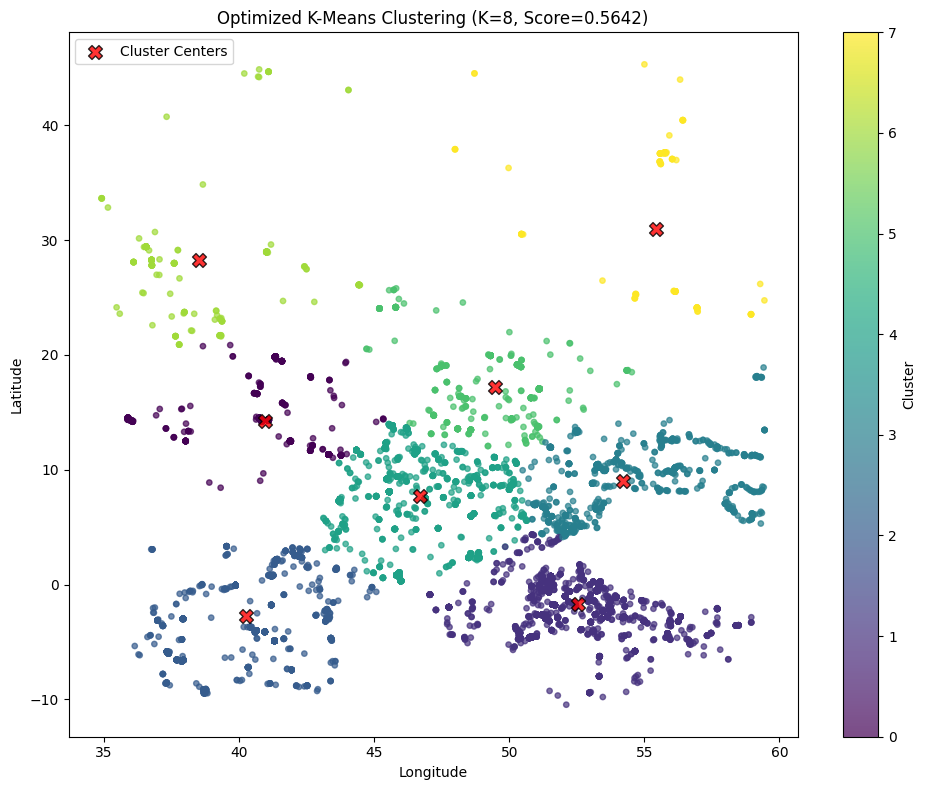

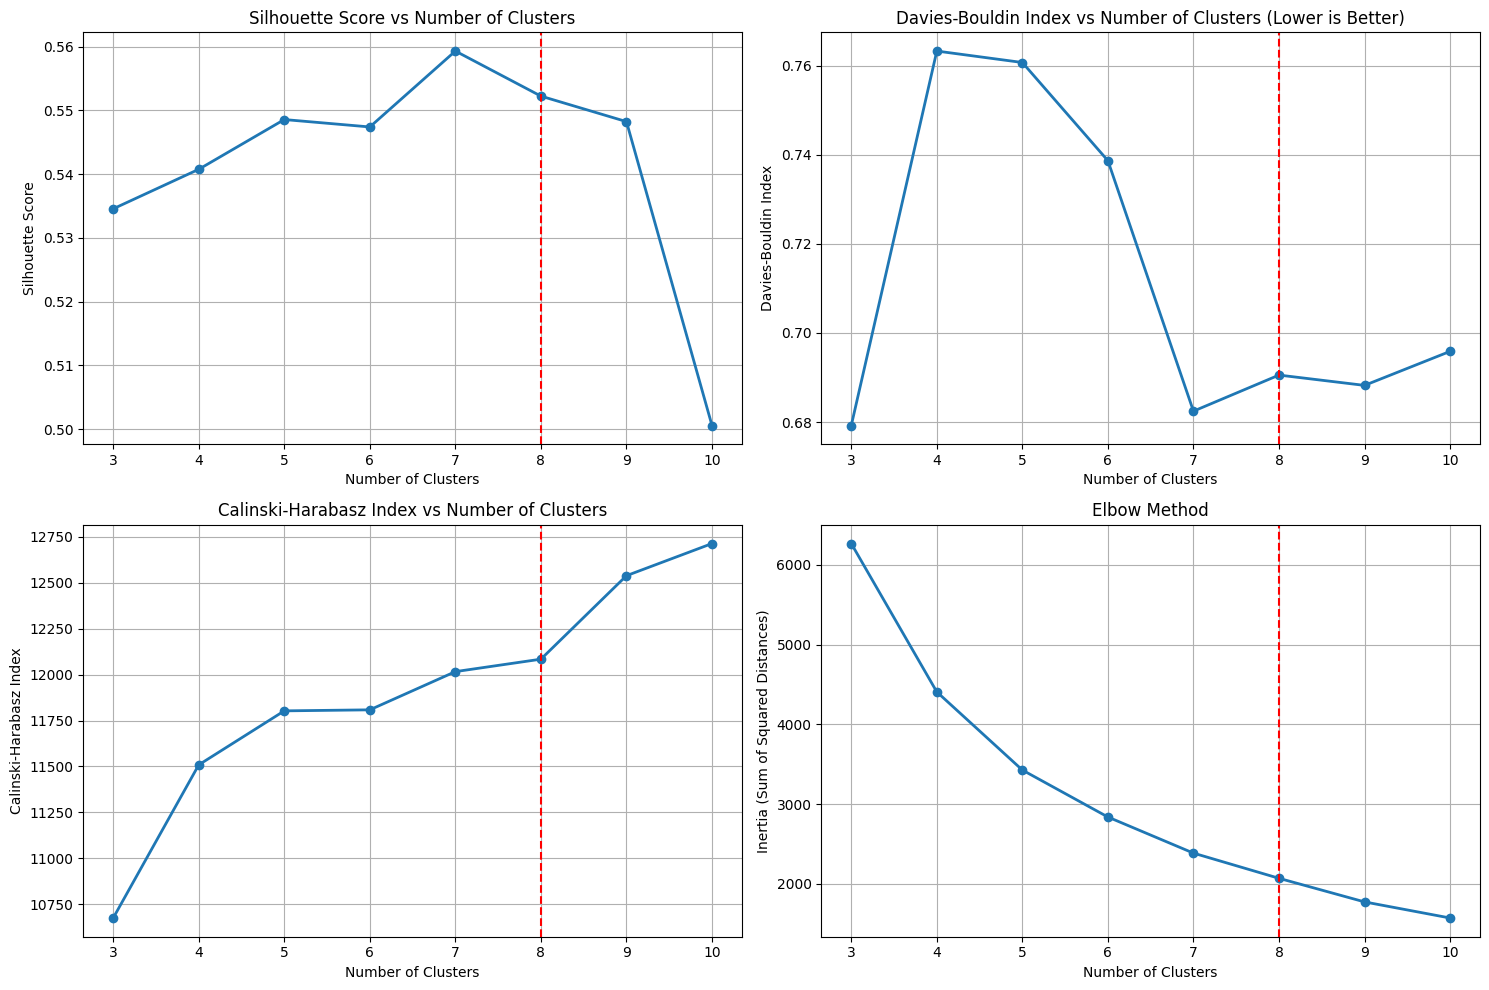

Best Parameters: {'n_clusters': 8, 'random_state': 42, 'init': 'k-means++'}
Best Silhouette Score: 0.5642
Best Davies-Bouldin Index: 0.6422
Best Calinski-Harabasz Score: 12154.5295


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import time

# Start timer
start_time = time.time()

# Assuming df contains Latitude & Longitude
X = df[['Longitude', 'Latitude']].values

# Scale the data (important for K-means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the parameter grid with more options
param_grid = {
    'n_clusters': np.arange(3, 11),  # Test K from 3 to 10
    'random_state': [0, 21, 42],  # Test different seeds
    'init': ['k-means++']  # Use k-means++ initialization for better convergence
}

# Function to evaluate a set of parameters
def evaluate_params(params):
    kmeans = KMeans(n_clusters=params['n_clusters'],
                    random_state=params['random_state'],
                    init=params['init'],
                    n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    # Calculate multiple metrics
    sil_score = silhouette_score(X_scaled, labels)
    dbi_score = davies_bouldin_score(X_scaled, labels)
    ch_score = calinski_harabasz_score(X_scaled, labels)

    inertia = kmeans.inertia_

    return {
        'params': params,
        'silhouette': sil_score,
        'davies_bouldin': dbi_score,
        'calinski_harabasz': ch_score,
        'inertia': inertia,
        'labels': labels
    }

# Parallel processing for faster grid search
results = Parallel(n_jobs=-1)(
    delayed(evaluate_params)(params) for params in ParameterGrid(param_grid)
)

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame([
    {**r['params'],
     'silhouette': r['silhouette'],
     'davies_bouldin': r['davies_bouldin'],
     'calinski_harabasz': r['calinski_harabasz'],
     'inertia': r['inertia']}
    for r in results
])

# Find best parameters based on silhouette score
best_idx = results_df['silhouette'].idxmax()
best_params = {k: results_df.loc[best_idx, k] for k in param_grid.keys()}
best_score = results_df.loc[best_idx, 'silhouette']
best_dbi = results_df.loc[best_idx, 'davies_bouldin']
best_ch = results_df.loc[best_idx, 'calinski_harabasz']
best_labels = results[best_idx]['labels']

# Train the best model
best_kmeans = KMeans(**best_params, n_init=10)
df['kmeans_cluster'] = best_kmeans.fit_predict(X_scaled)

# Calculate execution time
execution_time = time.time() - start_time
print(f"Execution time: {execution_time:.2f} seconds")

# Plot the optimized clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['Longitude'], df['Latitude'], c=df['kmeans_cluster'],
                      cmap='viridis', alpha=0.7, s=15)
plt.colorbar(scatter, label='Cluster')

# Add cluster centers
centers = scaler.inverse_transform(best_kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.8,
            marker='X', edgecolors='black', label='Cluster Centers')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Optimized K-Means Clustering (K={best_params['n_clusters']}, Score={best_score:.4f})")
plt.legend()
plt.tight_layout()
plt.savefig('optimized_kmeans_clusters.png', dpi=300)
plt.show()

# Plot metrics for different numbers of clusters
plt.figure(figsize=(15, 10))

# Plot 1: Silhouette Score
plt.subplot(2, 2, 1)
silhouette_by_k = results_df.groupby('n_clusters')['silhouette'].mean()
plt.plot(silhouette_by_k.index, silhouette_by_k.values, 'o-', linewidth=2)
plt.axvline(x=best_params['n_clusters'], color='r', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True)

# Plot 2: Davies-Bouldin Index
plt.subplot(2, 2, 2)
dbi_by_k = results_df.groupby('n_clusters')['davies_bouldin'].mean()
plt.plot(dbi_by_k.index, dbi_by_k.values, 'o-', linewidth=2)
plt.axvline(x=best_params['n_clusters'], color='r', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs Number of Clusters (Lower is Better)')
plt.grid(True)

# Plot 3: Calinski-Harabasz Index
plt.subplot(2, 2, 3)
ch_by_k = results_df.groupby('n_clusters')['calinski_harabasz'].mean()
plt.plot(ch_by_k.index, ch_by_k.values, 'o-', linewidth=2)
plt.axvline(x=best_params['n_clusters'], color='r', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index vs Number of Clusters')
plt.grid(True)

# Plot 4: Elbow Method
plt.subplot(2, 2, 4)
inertia_by_k = results_df.groupby('n_clusters')['inertia'].mean()
plt.plot(inertia_by_k.index, inertia_by_k.values, 'o-', linewidth=2)
plt.axvline(x=best_params['n_clusters'], color='r', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method')
plt.grid(True)

plt.tight_layout()
plt.savefig('kmeans_metrics.png', dpi=300)
plt.show()

# Print detailed results
print(f"Best Parameters: {best_params}")
print(f"Best Silhouette Score: {best_score:.4f}")
print(f"Best Davies-Bouldin Index: {best_dbi:.4f}")
print(f"Best Calinski-Harabasz Score: {best_ch:.4f}")

# Export results to CSV for further analysis
results_df.to_csv('kmeans_grid_search_results.csv', index=False)

<h3>2) Density-Based Spatial Clustering of Applications with Noise</h3>

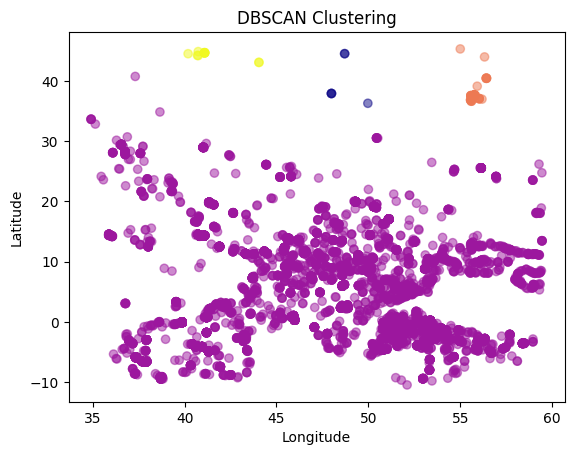

In [ ]:
from sklearn.cluster import DBSCAN

# Fit DBSCAN
dbscan = DBSCAN(eps=0.78, min_samples=12)  # Adjust `eps` based on data density
df['dbscan_cluster'] = dbscan.fit_predict(X_scaled)

# Visualize DBSCAN
plt.scatter(df['Longitude'], df['Latitude'], c=df['dbscan_cluster'], cmap='plasma', alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("DBSCAN Clustering")
plt.show()

<h3>3) Gaussian Mixture Model</h3>

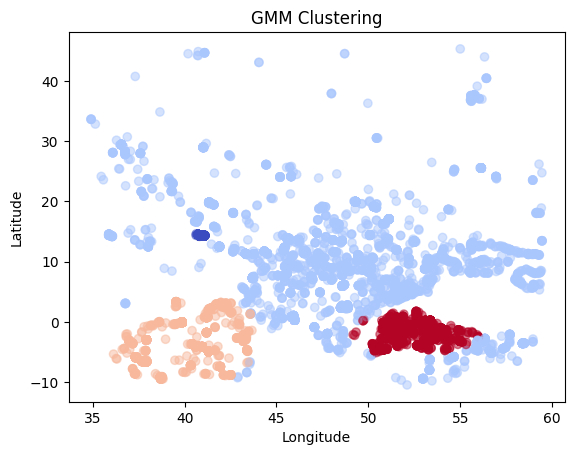

In [ ]:
from sklearn.mixture import GaussianMixture

# Fit GMM
gmm = GaussianMixture(n_components=4, random_state=42)
df['gmm_cluster'] = gmm.fit_predict(X_scaled)

# Visualize GMM
plt.scatter(df['Longitude'], df['Latitude'], c=df['gmm_cluster'], cmap='coolwarm', alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("GMM Clustering")
plt.show()

<h3>4) Hierarchical Clustering</h3>

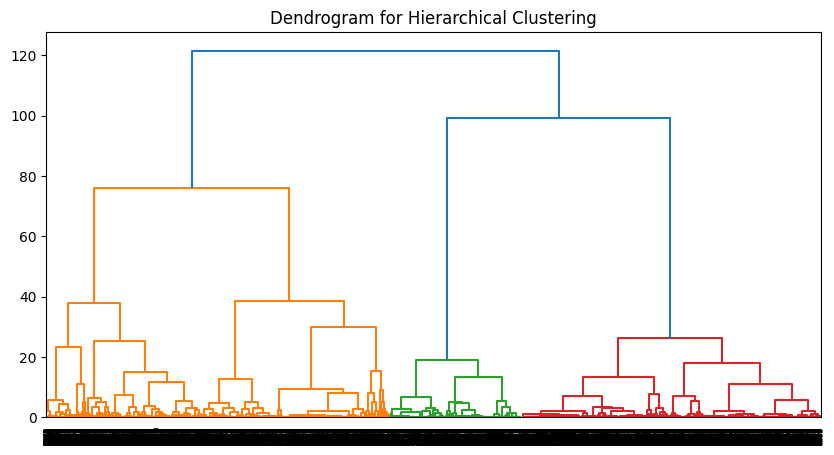

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering
linked = linkage(X_scaled, method='ward')

# Dendrogram visualization
plt.figure(figsize=(10, 5))
dendrogram(linked)
plt.title("Dendrogram for Hierarchical Clustering")
plt.show()

<h2>Evaluating Clusters</h2>

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Evaluate models
models = {'KMeans': kmeans.labels_, 'DBSCAN': dbscan.labels_, 'GMM': gmm.predict(X_scaled)}

for name, labels in models.items():
    if len(set(labels)) > 1:  # Silhouette score requires at least 2 clusters
        print(f"{name}:")
        print("  Silhouette Score:", silhouette_score(X_scaled, labels))
        print("  Davies-Bouldin Index:", davies_bouldin_score(X_scaled, labels))


KMeans:
  Silhouette Score: 0.5641613628678133
  Davies-Bouldin Index: 0.6421843177277118
DBSCAN:
  Silhouette Score: 0.5493727872579042
  Davies-Bouldin Index: 0.4103792336923212
GMM:
  Silhouette Score: 0.35243367047638924
  Davies-Bouldin Index: 0.8418150265158224


In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Assuming 'X' is your dataset and 'n_clusters' is the number of clusters you want
n_clusters = 4  # Change this based on the dendrogram
hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
labels_hierarchical = hierarchical.fit_predict(X)

# Compute the metrics
silhouette = silhouette_score(X, labels_hierarchical)
davies_bouldin = davies_bouldin_score(X, labels_hierarchical)

print("Hierarchical Clustering:")
print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")


Hierarchical Clustering:
Silhouette Score: 0.5081337689033051
Davies-Bouldin Index: 0.8524293352603025


In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Function to evaluate clustering models
def evaluate_clustering(X, labels):
    if len(set(labels)) > 1:  # At least 2 clusters needed for metric calculation
        return silhouette_score(X, labels)
    return -1  # Invalid score if only one cluster

models = {
    "KMeans": KMeans(n_clusters=8, random_state=42),
    "DBSCAN": DBSCAN(eps=0.686, min_samples=13),
    "Agglomerative": AgglomerativeClustering(n_clusters=5),
    "GMM": GaussianMixture(n_components=4, random_state=42)
}

best_model = None
best_score = -1

for name, model in models.items():
    model.fit(X_scaled)
    labels = model.labels_ if hasattr(model, 'labels_') else model.predict(X_scaled)
    score = evaluate_clustering(X_scaled, labels)
    print(f"{name} Clustering: Silhouette Score = {score}")

    if score > best_score:
        best_score = score
        best_model = name

print(f"Best model: {best_model} with score {best_score}")



KMeans Clustering: Silhouette Score = 0.5641613628678133
DBSCAN Clustering: Silhouette Score = 0.5475115696846222
Agglomerative Clustering: Silhouette Score = 0.4954016223602207
GMM Clustering: Silhouette Score = 0.35243367047638924
Best model: KMeans with score 0.5641613628678133


<h2>Visualizing Clusters on Real World Map</h2>

In [ ]:
import folium
from folium.plugins import MarkerCluster

# Create map centered at mean coordinates
map_center = [df["Latitude"].mean(), df["Longitude"].mean()]
map_ = folium.Map(location=map_center, zoom_start=12)

# Use MarkerCluster for efficient handling of many points
marker_cluster = MarkerCluster().add_to(map_)

# Add all points at once using list comprehension instead of loop
points = df[["Latitude", "Longitude"]].values.tolist()
for point in points:
    folium.CircleMarker(
        location=point,
        radius=5,
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.7,
        weight=1
    ).add_to(marker_cluster)

# Alternative faster approach using FeatureGroup (uncomment to use)
# feature_group = folium.FeatureGroup(name="Locations").add_to(map_)
# for point in points:
#     folium.CircleMarker(
#         location=point,
#         radius=5,
#         color="blue",
#         fill=True,
#         fill_color="blue",
#         fill_opacity=0.7,
#         weight=1
#     ).add_to(feature_group)

# Save and display map
map_.save("clusters_map.html")

In [ ]:
# Display the map inside Jupyter Notebook
display(map_)